# Time Series Analysis of Hourly Energy demand


The dataset is unique because it contains hourly data for electrical consumption and the respective forecasts by the TSO for consumption and pricing. We focus on predicting electrical comsumption better than the already present forecast in the data. The metrics we are using for comparision is __Mean Absolute Percentage Error or MAPE__

__The data is multivariate time series as it contains multiple features. We use only a single feature thereby handling univariate time series__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [3]:
pd.set_option('display.max_columns', None)
data=pd.read_csv("energy_dataset.csv")

In [4]:
data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [5]:
data.shape

(35064, 29)

In [6]:
data.isnull().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

__MAPE Formula (Mean absolute percentage error)__

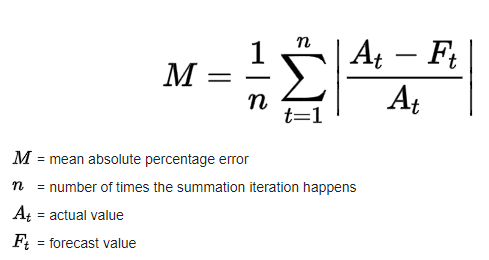

In [7]:
#Lets calculate MAPE
Mape=np.mean(np.abs((data['total load actual']-data['total load forecast'])/data['total load actual']))*100
print("MAPE of data forecasted: ",Mape)

MAPE of data forecasted:  1.096023073723821


### Preprocessing
Here we extract the single feature we will predict, i.e. total load actual. Then we scale the feature using a MinMaxScaler. To prepare the data for the models, use create_dataset function which takes the data and creates chunks of it based on the look_back.

The preprocessing works as follows: Example data: [1,2,3,4,5] After preprocessing (x -> y):

[1,2] -> [3]<br>
[2,3] -> [4]<br>
[3,4] -> [5]<br>

when look_back is set to 2. This preprocessing is only required for LSTM. Rest of the models take input as a series with single feature.

In [8]:
temp = data.copy() # make temporary copy of dataframe
dataset = temp['total load actual'].dropna().values # numpy.ndarray of the actual load
dataset = dataset.astype('float32') 
dataset = np.reshape(dataset, (-1, 1)) # reshape to one feature; required for the models

scaler = MinMaxScaler(feature_range=(0, 1)) # Min Max scaler
dataset = scaler.fit_transform(dataset) # fit and transform the dataset

# Train and Test splits
train_size = int(len(dataset) * 0.80) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25 # timesteps to lookback for predictions
X_train, trainY = create_dataset(train, look_back)
X_test, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print("Shapes: \nTraining set: {}, Testing set: {}".format(X_train.shape, X_test.shape))
print("Sample from training set: \n{}".format(X_train[0]))

Shapes: 
Training set: (27996, 1, 25), Testing set: (6980, 1, 25)
Sample from training set: 
[[0.31966567 0.27600765 0.20427442 0.14124662 0.09676152 0.08113521
  0.08570558 0.10168016 0.08936191 0.11299729 0.1832071  0.23966217
  0.26516938 0.2904153  0.2886306  0.23883522 0.22098899 0.2422303
  0.36589193 0.43436062 0.47762692 0.5018717  0.47836685 0.38117003
  0.39300954]]


## AR Model

In [9]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(train,lags=25)
model_fit = model.fit()

In [10]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Test Mean Absolute Error: 3789.612412922715
Test Root Mean Squared Error: 4453.831950176531


In [11]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

Testing MAPE: 13.554581287341472


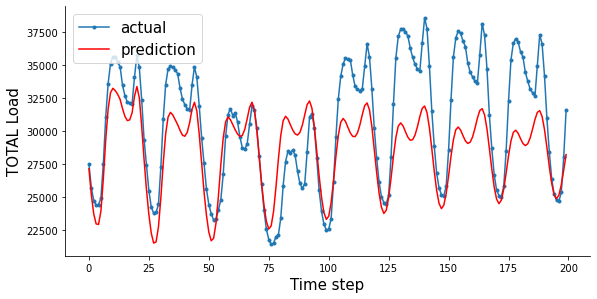

In [12]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();


## MA Model

In [84]:
test_predict = np.mean(X_test, axis=2)
print('Test Mean Absolute Error:', mean_absolute_error(testY, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(testY, test_predict)))

Test Mean Absolute Error: 0.14497761
Test Root Mean Squared Error: 0.17464507


In [85]:
# test_predict=np.insert(test_predict,[1],[[0.56694525],[0.56694525],],axis=0)
Y_test.shape,test_predict.shape


((6980,), (6980, 1))

In [86]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test))*100
print("Testing MAPE: {}".format(mape))

Testing MAPE: 59.13496017456055


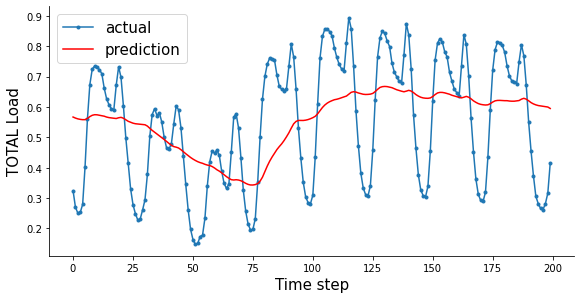

In [15]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, testY[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## ARMA Model

In [22]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(2,0, 1))
model_fit = model.fit()

In [23]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Test Mean Absolute Error: 3862.8977742162656
Test Root Mean Squared Error: 4521.677939248239


In [24]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

Testing MAPE: 13.815386820396187


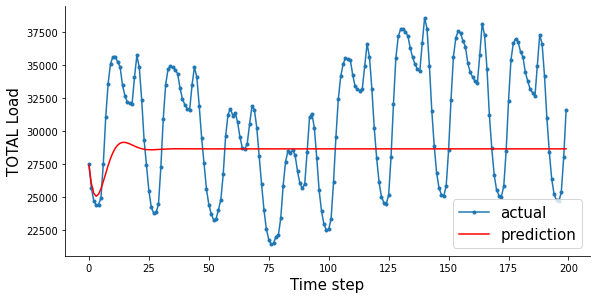

In [25]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## ARIMA Model

In [30]:
model = ARIMA(train, order=(2, 1, 1))
model_fit = model.fit()

In [31]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Test Mean Absolute Error: 4003.7551304398335
Test Root Mean Squared Error: 4783.895310275904


In [32]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

Testing MAPE: 15.14980448888904


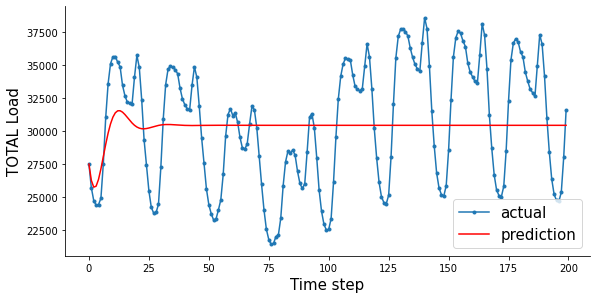

In [33]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();